# Installing and importing required libraries:

In [1]:
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install seaborn
%pip install sklearn
%pip install nltk
%pip install spacy
%pip install openpyxl

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take som

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import DBSCAN,KMeans,AgglomerativeClustering
from sklearn.metrics import silhouette_score
import numpy as np
from sklearn.manifold import TSNE

import nltk
#import spacy
#import re
nltk.download('punkt')
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.decomposition import PCA  
from scipy.stats import zscore
nltk.download('punkt_tab')
from scipy.sparse import hstack
from sklearn.metrics.pairwise import cosine_similarity

[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Exploratory Data Analysis:

Here , we will observe all the charecteristics of the dataset such as datatypes, Dimensions, Duplicates, Importent features, outliers using boxplot histogram and other nature of all the features using various visualization techniques.

In [5]:
# Importing and coverting the dataset into a dataframe
df=pd.read_excel("Hollywood_tracks.xlsx")

In [6]:
# Preview of the dataset
df.head()

,index,Name,Artist,Genre,Popularity,Acousticness,Danceability,Energy,Instrumentalness,Liveness,Loudness,Speechiness,Tempo,Valence,Mode,Key,Duration_ms,release_date,is_english
0,0,Blister In The Sun,Violent Femmes,acoustic,71,0.3160,0.726,0.537,0.00000,0.0707,-8.896,0.1140,96.889,0.882,1,0,145706,1983-01-01,True
1,1,Love Song,Sara Bareilles,acoustic,73,0.0208,0.583,0.786,0.00000,0.1880,-3.142,0.0301,123.055,0.573,0,2,258826,2007-07-03,True
2,3,Hold On,Chord Overstreet,acoustic,77,0.4690,0.618,0.443,0.00000,0.0829,-9.681,0.0526,119.949,0.167,1,2,198853,2017-02-03,True
3,5,You Are the Best Thing,Ray LaMontagne,acoustic,67,0.0304,0.578,0.727,0.00002,0.1720,-4.872,0.0332,170.593,0.885,1,10,231840,2008-10-13,True
4,6,I Won't Give Up,Jason Mraz,acoustic,67,0.6940,0.483,0.303,0.00000,0.1150,-10.058,0.0429,133.406,0.139,1,4,240165,2012-04-13,True


In [7]:
# Just dropping unnecessary columns
df=df.drop(['index','is_english'],axis=1)

In [7]:
# Information of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13794 entries, 0 to 13793
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              13794 non-null  object 
 1   Artist            13794 non-null  object 
 2   Genre             13794 non-null  object 
 3   Popularity        13794 non-null  int64  
 4   Acousticness      13794 non-null  float64
 5   Danceability      13794 non-null  float64
 6   Energy            13794 non-null  float64
 7   Instrumentalness  13794 non-null  float64
 8   Liveness          13794 non-null  float64
 9   Loudness          13794 non-null  float64
 10  Speechiness       13794 non-null  float64
 11  Tempo             13794 non-null  float64
 12  Valence           13794 non-null  float64
 13  Mode              13794 non-null  int64  
 14  Key               13794 non-null  int64  
 15  Duration_ms       13794 non-null  int64  
 16  release_date      13794 non-null  object

#### Null Values

In [8]:
print('Count of null values:',df.isnull().sum().sum())

Count of null values: 0


As we can see there are no null values in the dataset.

#### Duplicated values

In [9]:
print('Count of duplicated values:')
df.duplicated().sum()

Count of duplicated values:


np.int64(8754)

In [60]:
df[df[['Name','Artist']].duplicated()]

,Name,Artist,Genre,Popularity,Acousticness,Danceability,Energy,Instrumentalness,Liveness,Loudness,Speechiness,Tempo,Valence,Mode,Key,Duration_ms,release_date,Release_Year
37,Hold On,Chord Overstreet,acoustic,77,0.46900,0.618,0.443,0.000000,0.0829,-9.681,0.0526,119.949,0.167,1,2,198853,2017-02-03,2017
38,Love Song,Sara Bareilles,acoustic,73,0.02080,0.583,0.786,0.000000,0.1880,-3.142,0.0301,123.055,0.573,0,2,258826,2007-07-03,2007
39,I Won't Give Up,Jason Mraz,acoustic,67,0.69400,0.483,0.303,0.000000,0.1150,-10.058,0.0429,133.406,0.139,1,4,240165,2012-04-13,2012
40,Blister In The Sun,Violent Femmes,acoustic,71,0.31600,0.726,0.537,0.000000,0.0707,-8.896,0.1140,96.889,0.882,1,0,145706,1983-01-01,1983
42,Naked as We Came,Iron & Wine,acoustic,67,0.65300,0.386,0.205,0.044800,0.1060,-16.699,0.0366,172.373,0.623,1,4,152613,2004-03-23,2004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13786,Pump It Louder,Tiësto,trance,63,0.00789,0.660,0.942,0.000018,0.8340,-2.273,0.1850,126.017,0.543,1,4,158571,2022-10-07,2022
13787,My City (feat. Katy Tiz),Tiësto,trance,59,0.00169,0.668,0.943,0.548000,0.1300,-3.375,0.0498,128.011,0.195,1,2,151874,2024-05-15,2024
13788,Alone In A Room,Asking Alexandria,trance,63,0.00251,0.482,0.946,0.000000,0.0466,-3.230,0.0852,135.071,0.284,0,4,245861,2017-12-15,2017
13790,Don't Be Shy,Tiësto,trance,66,0.19800,0.770,0.787,0.000000,0.2620,-3.748,0.0583,119.986,0.513,0,11,140500,2023-04-21,2023


There are 10,159 duplicate values when considering both the name and artist columns. We'll drop these columns because imputing those values would reduce the accuracy of the model

#### Categorical columns:

In [10]:
print('Artist, genre, Mode and Key are the categorical columns.\n')
genres=df['Genre'].unique()
print("List of genres:\n",genres)
print("\nCount of genres:",df['Genre'].nunique())
print("\nList of unique values in mode are",df['Mode'].unique())
print('\nList of unique values in key are',df['Key'].unique())
print('\nNo of unique values in Artist are',df['Artist'].nunique())

Artist, genre, Mode and Key are the categorical columns.

List of genres:
 ['acoustic' 'afrobeat' 'alt-rock' 'alternative' 'ambient' 'anime'
 'black-metal' 'bluegrass' 'blues' 'brazil' 'breakbeat' 'british'
 'cantopop' 'chicago-house' 'children' 'chill' 'classical' 'club' 'comedy'
 'country' 'dance' 'dancehall' 'death-metal' 'deep-house' 'detroit-techno'
 'disco' 'drum-and-bass' 'dub' 'dubstep' 'edm' 'electro' 'electronic'
 'emo' 'folk' 'french' 'funk' 'garage' 'german' 'gospel' 'goth'
 'grindcore' 'groove' 'grunge' 'guitar' 'happy' 'hard-rock' 'hardcore'
 'hardstyle' 'heavy-metal' 'hip-hop' 'honky-tonk' 'house' 'idm' 'indian'
 'indie' 'indie-pop' 'industrial' 'iranian' 'j-dance' 'j-idol' 'j-pop'
 'j-rock' 'jazz' 'k-pop' 'kids' 'latin' 'latino' 'malay' 'mandopop'
 'metal' 'metalcore' 'minimal-techno' 'mpb' 'new-age' 'opera' 'pagode'
 'party' 'piano' 'pop' 'pop-film' 'power-pop' 'progressive-house'
 'psych-rock' 'punk' 'punk-rock' 'r-n-b' 'reggae' 'reggaeton' 'rock'
 'rock-n-roll' 'rock

#### Text columns:

In [61]:
text_features = [feature for feature in df.columns if df[feature].dtypes == 'O']
print('Number of numerical variables:', len(text_features))
df[text_features].head(2)

Number of numerical variables: 3


,Name,Artist,Genre
0,Blister In The Sun,Violent Femmes,acoustic
1,Love Song,Sara Bareilles,acoustic


#### Numerical Columns:

In [8]:
numerical_features = [feature for feature in df.columns if df[feature].dtypes != 'O']
print('Number of numerical variables:', len(numerical_features))
df[numerical_features].head(2)

Number of numerical variables: 13


,Popularity,Acousticness,Danceability,Energy,Instrumentalness,Liveness,Loudness,Speechiness,Tempo,Valence,Mode,Key,Duration_ms
0,71,0.3160,0.726,0.537,0.0,0.0707,-8.896,0.1140,96.889,0.882,1,0,145706
1,73,0.0208,0.583,0.786,0.0,0.1880,-3.142,0.0301,123.055,0.573,0,2,258826


In [9]:
# description of the dataset:
df.describe()

,Popularity,Acousticness,Danceability,Energy,Instrumentalness,Liveness,Loudness,Speechiness,Tempo,Valence,Mode,Key,Duration_ms
count,13794.000000,13794.000000,13794.000000,13794.000000,13794.000000,13794.000000,13794.000000,13794.000000,13794.000000,13794.000000,13794.000000,13794.000000,1.379400e+04
mean,64.303175,0.262671,0.579024,0.648000,0.137969,0.183070,-8.224556,0.077675,122.826659,0.498532,0.635059,5.347832,2.167082e+05
std,16.442691,0.319897,0.174070,0.252896,0.292506,0.152333,5.433831,0.080799,28.899176,0.258976,0.481431,3.556048,7.556606e+04
min,2.000000,0.000001,0.000000,0.000020,0.000000,0.015700,-43.938000,0.000000,0.000000,0.000000,0.000000,0.000000,3.096500e+04
25%,55.000000,0.009200,0.467000,0.473750,0.000000,0.093000,-10.050000,0.035000,101.814000,0.288000,0.000000,2.000000,1.708900e+05
50%,66.000000,0.099250,0.592000,0.697000,0.000099,0.121000,-6.655000,0.048100,123.046000,0.496500,1.000000,6.000000,2.094890e+05
75%,77.000000,0.466000,0.705000,0.862000,0.037900,0.222000,-4.804000,0.081175,139.933000,0.709000,1.000000,8.000000,2.448795e+05
max,97.000000,0.996000,0.980000,1.000000,0.999000,0.984000,1.221000,0.947000,235.907000,0.985000,1.000000,11.000000,1.400000e+06


After fetching the description of the dataset we see that are 50% null values but when we look into the instrumentalness columns it has been observed that there are many values which are numerically 0 but not explicitly null (0) .

In [5]:
# To find values that are numerically zero but not explicitly null:

# 0r simply we can use the below one line code
(df['Instrumentalness']==0.00000).sum()

4152

From the above output, it can be observed that there are 4157 rows which is having numerically zero values.
We can drop these rows (optional, but if we drop the rows it will lead to loss of necessary dataset so we will remove the column "instrumentalness".

In [8]:
# Convert the date column to datetime
df['release_date'] = pd.to_datetime(df['release_date'],format='ISO8601')

# Extract the year for the visualization purpose
df['Release_Year'] = df['release_date'].dt.year


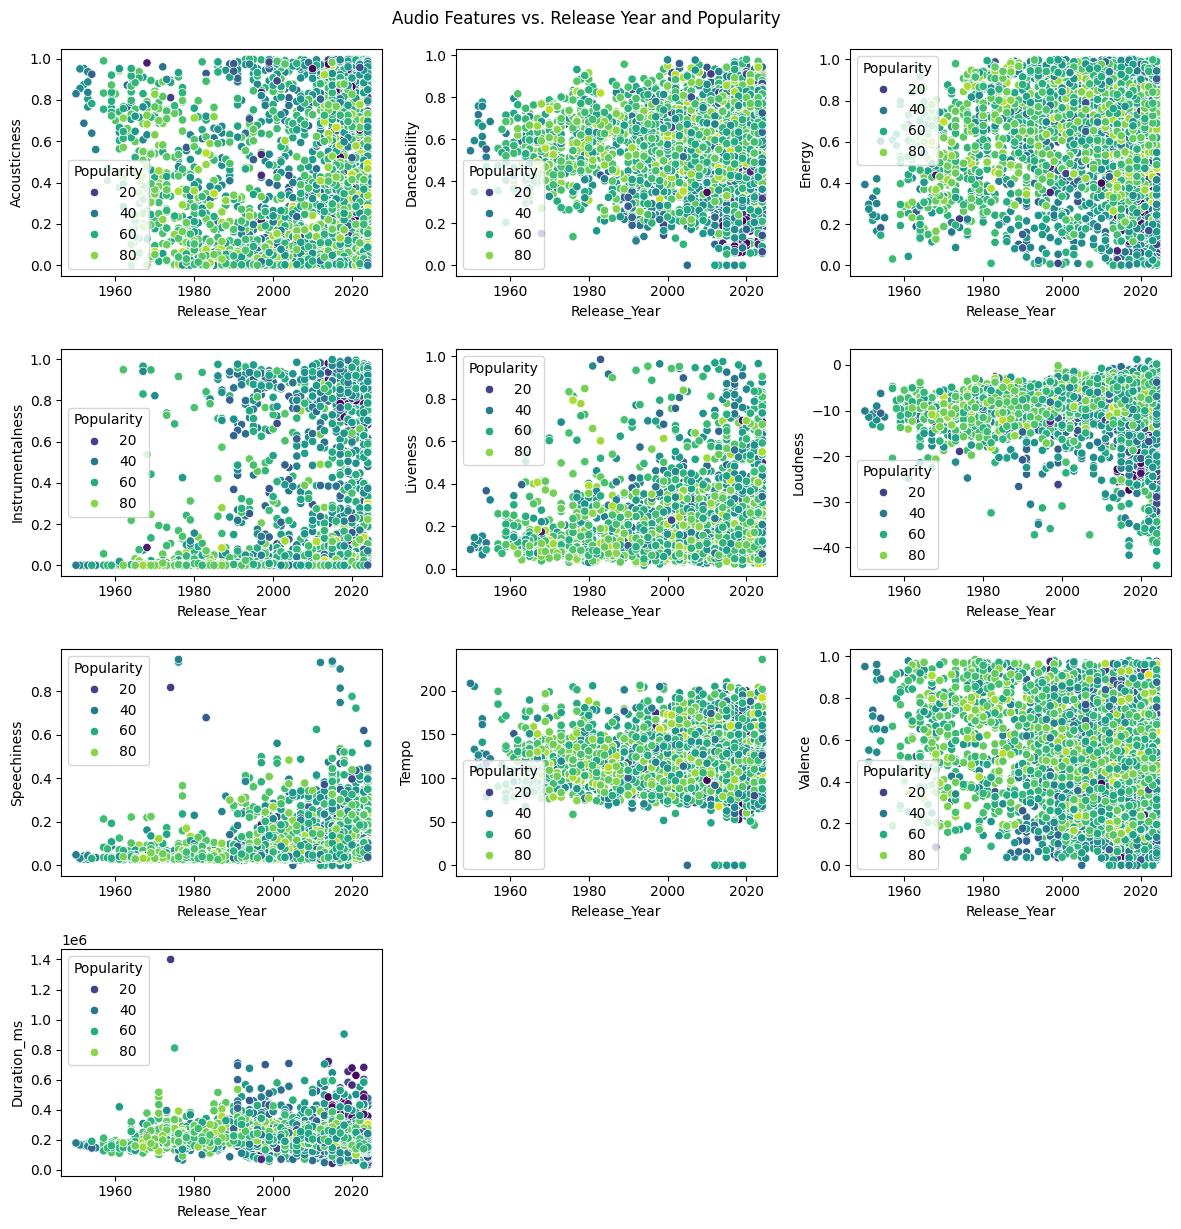

In [9]:
# Define the audio features
features = ['Acousticness', 'Danceability',
        'Energy', 'Instrumentalness', 'Liveness', 'Loudness',
       'Speechiness', 'Tempo', 'Valence','Duration_ms']

plt.figure(figsize=(12,12))
# Plot each feature against Popularity and Release Year
for i, feature in enumerate(features,start=1):
    plt.subplot(4,3,i)
    sns.scatterplot(x='Release_Year', y=feature, hue='Popularity', data=df, palette='viridis')
    
plt.tight_layout()
plt.suptitle('Audio Features vs. Release Year and Popularity', y=1.02)
plt.show()


+ The graph illustrates the changes in audio feature popularity over the years.
+ For instance, acousticness scores between 0 and 0.6 have consistently been popular.
+ Danceability scores in the range of 0.4 to 0.8 have remained popular over time.
+ The popularity of energy scores above 0.4 has been increasing over the years.
+ Loudness levels between 0 and -10 dB are notably popular, as indicated by their consistently low values.
+ Songs with moderate speechiness have seen a rise in popularity over the years.

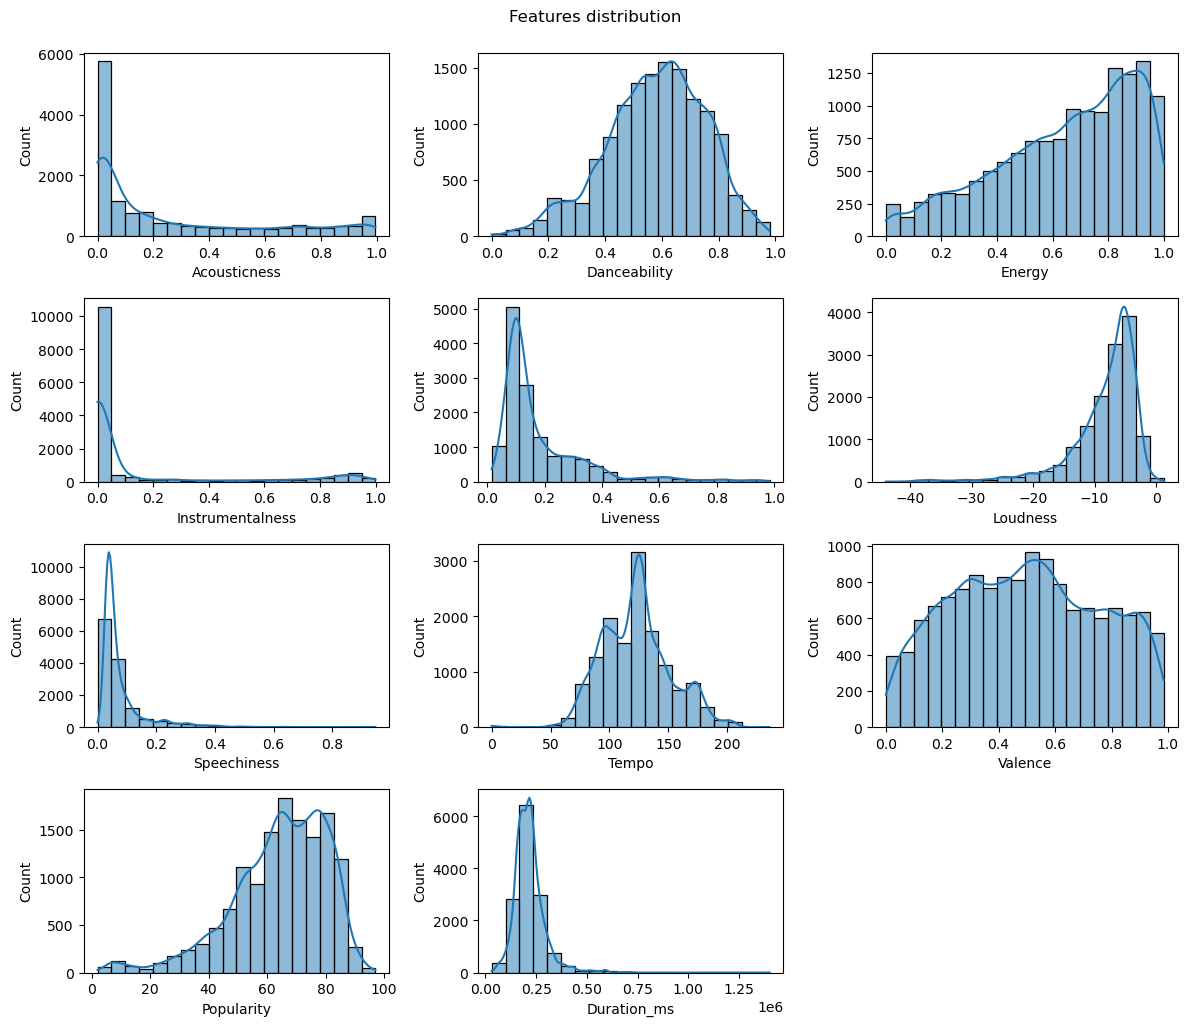

In [238]:
# Feature distributions
features = ['Acousticness', 'Danceability',
        'Energy', 'Instrumentalness', 'Liveness', 'Loudness',
       'Speechiness', 'Tempo', 'Valence','Popularity','Duration_ms']

plt.figure(figsize=(12,12))
# Plot each feature against Popularity and Release Year
for i, feature in enumerate(features,start=1):
    plt.subplot(5,3,i)
    sns.histplot(df[feature], bins=20,kde=True)
    
plt.tight_layout()
plt.suptitle('Features distribution', y=1.02)
plt.show()

The above graphs shows the feature distributions.  
As we can see some of the features are right skewed like acousticness, instrumentalness, liveness,speechiness and some of them are slightly left skewed like danceability, energy, popularity.  
Some of the features are slight normal distributions like tempo, duration_ms, valence.

This left and right skewed histogram throw a light on the presence of outliers so we will check for outliers and deal with it.


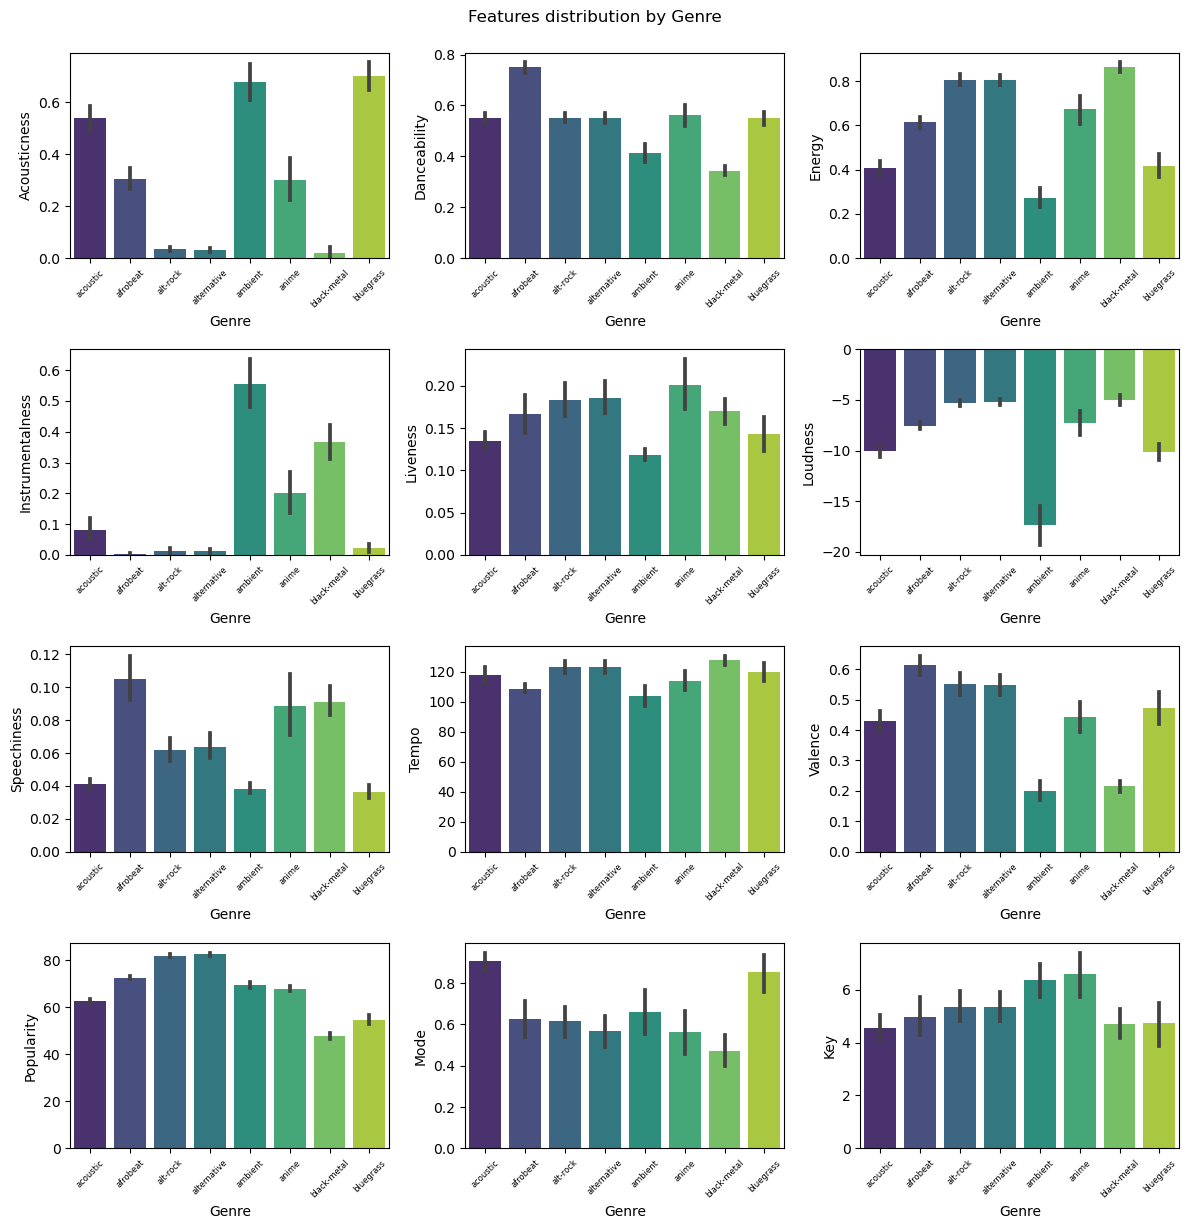

In [73]:
# Genre vs all the features
features = ['Acousticness', 'Danceability',
        'Energy', 'Instrumentalness', 'Liveness', 'Loudness',
       'Speechiness', 'Tempo', 'Valence','Popularity','Mode','Key']
plt.figure(figsize=(12,12))

for i, feature in enumerate(features,start=1):
    plt.subplot(4,3,i)
    sns.barplot(data=df.iloc[:1000,:], x='Genre', y=feature, palette='viridis')
    plt.xticks(rotation=45,fontsize=6)
plt.tight_layout()
plt.suptitle('Features distribution by Genre',y=1.02)
plt.show()

The above graph shows how the features distributed by genres.  
We have just taken first 10 genres.   
We can conclude:    
The tempo is kind of similar for all the 10 genres.  
Instrumentalness changing drastically for different genres etc.  

In [4]:
corr=df[['Popularity', 'Acousticness', 'Danceability',
       'Duration_ms', 'Energy', 'Instrumentalness', 'Liveness', 'Loudness',
       'Speechiness', 'Tempo', 'Valence']].corr()

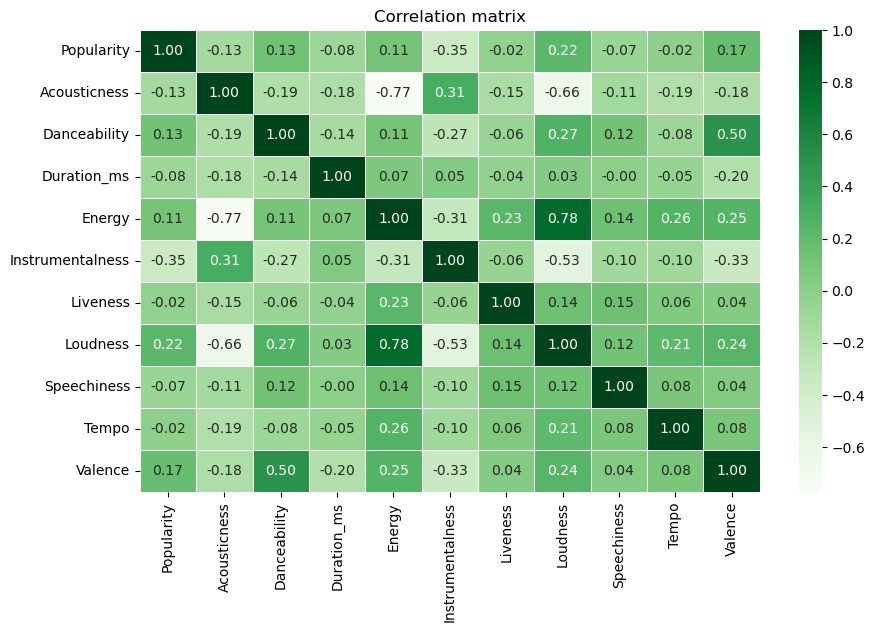

In [5]:
plt.figure(figsize=(10,6))
sns.heatmap(corr,annot=True, fmt='.2f',cmap='Greens',linewidths=0.5)
plt.title('Correlation matrix')
plt.show()

In [31]:
print("Features having collinearity greater than 0.6")
for i, row in corr.iterrows():
    for col in corr.columns:
        corr_value=row[col]
        if abs(corr_value) > 0.5 and (i!= col and i < col):
            print(f"{i}, {col}: {corr_value}")
        else:
            continue

Features having collinearity greater than 0.6
Acousticness, Energy: -0.7734411569480996
Acousticness, Loudness: -0.6568653006988825
Danceability, Valence: 0.5023430387823572
Energy, Loudness: 0.784360806624906
Instrumentalness, Loudness: -0.5269294347100901


It can be seen easily that there exist collinearity between the varibles "Acoustiness and energy" ,'acoustiness and loudness'. These two are negatively correlated (lighter the colour negative is the correlation)/

Also we can see that there is the positive correlation between  the Loudness and energy (0.78).

So we will delete the most common correlated features to deal with the multicollinearity issue among the features.

Loudness and acousticness are having multicollinearity so we will be dropping loudness and acousticness.

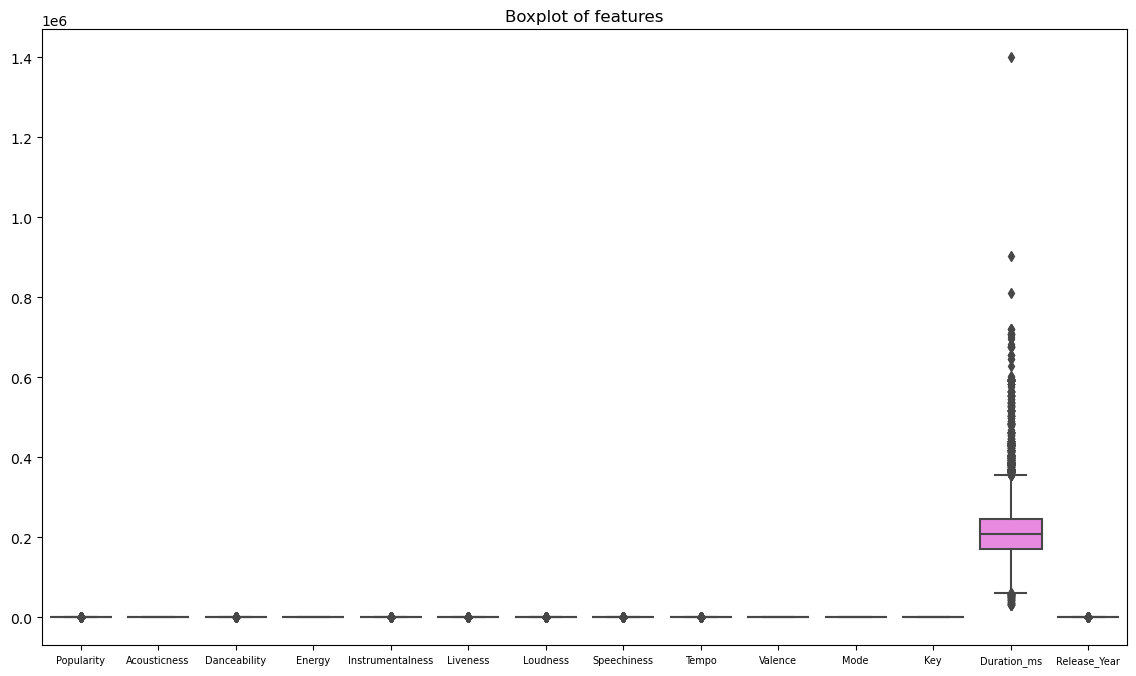

In [77]:
plt.figure(figsize=(14,8))
sns.boxplot(df)
plt.xticks(fontsize=7)
plt.title('Boxplot of features')
plt.show()

As we can see from above, the duration_ms is the only feature having outliers.It could be because of scaling as the values are on large scale. Hence we are ignoring it for now.

In [78]:
df.columns

Index(['Name', 'Artist', 'Genre', 'Popularity', 'Acousticness', 'Danceability',
       'Energy', 'Instrumentalness', 'Liveness', 'Loudness', 'Speechiness',
       'Tempo', 'Valence', 'Mode', 'Key', 'Duration_ms', 'release_date',
       'Release_Year'],
      dtype='object')

# Data Preprocessing:

In [10]:
#dropping duplicates as per previous analysis
df_cleaned = df.drop_duplicates(subset=['Name', 'Artist'])
df_cleaned=df_cleaned.reset_index()

In [11]:
# Dropiing Loudness ,acousticness, instrumentalness, release date, release year as per previous analysis for multi- collinearity, null values.
df_cleaned=df_cleaned.drop(['Loudness','Acousticness','index','release_date','Release_Year','Instrumentalness'], axis=1)

In [12]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3635 entries, 0 to 3634
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          3635 non-null   object 
 1   Artist        3635 non-null   object 
 2   Genre         3635 non-null   object 
 3   Popularity    3635 non-null   int64  
 4   Danceability  3635 non-null   float64
 5   Energy        3635 non-null   float64
 6   Liveness      3635 non-null   float64
 7   Speechiness   3635 non-null   float64
 8   Tempo         3635 non-null   float64
 9   Valence       3635 non-null   float64
 10  Mode          3635 non-null   int64  
 11  Key           3635 non-null   int64  
 12  Duration_ms   3635 non-null   int64  
dtypes: float64(6), int64(4), object(3)
memory usage: 369.3+ KB


#### Standardization:

In [13]:
scaler=StandardScaler()
standardized=scaler.fit_transform(df_cleaned[['Popularity', 'Danceability',
       'Duration_ms', 'Energy', 'Liveness',
       'Speechiness', 'Tempo', 'Valence']])

sd_df = pd.DataFrame(standardized, columns=['Popularity', 'Danceability',
        'Energy', 'Liveness', 
       'Speechiness', 'Tempo', 'Valence','Duration_ms'])


In our model, StandardScaler is preferred because it ensures that all features contribute equally to the clustering process by standardizing them to have a mean of 0 and variance of 1. This prevents any single feature from dominating due to its scale, which is critical in algorithms like K-Means that rely on distance calculations.

In [14]:
# Concatenating the transformed columns to the categorical columns
transformed_df=pd.concat([df_cleaned[['Name','Genre','Artist','Mode','Key']],sd_df],axis=1)

In [15]:
transformed_df.head()

,Name,Genre,Artist,Mode,Key,Popularity,Danceability,Energy,Liveness,Speechiness,Tempo,Valence,Duration_ms
0,Blister In The Sun,acoustic,Violent Femmes,1,0,0.753897,0.836503,-0.833970,-0.371914,-0.742964,0.325874,-0.840646,1.480190
1,Love Song,acoustic,Sara Bareilles,0,2,0.868316,0.059062,0.464556,0.577851,-0.011538,-0.572295,0.023950,0.325513
2,Hold On,acoustic,Chord Overstreet,1,2,1.097156,0.249345,-0.223885,-0.730460,-0.666890,-0.331428,-0.078681,-1.191635
3,You Are the Best Thing,acoustic,Ray LaMontagne,1,10,0.525057,0.031879,0.154779,0.352806,-0.111306,-0.539109,1.594734,1.491401
4,I Won't Give Up,acoustic,Jason Mraz,1,4,0.525057,-0.484602,0.250343,-1.264465,-0.466730,-0.435268,0.365975,-1.296266


#### Dropping outliers

We found several outliers but we will only remove those with standardized values greater than 3 or less than -3.

In [16]:

threshold=3

zscores= np.abs(transformed_df.iloc[:,5:].apply(zscore))
# Filter the DataFrame to exclude rows with any z-score above the threshold
filtered_df = transformed_df[(zscores < threshold).all(axis=1)]

filtered_df=filtered_df.reset_index()

filtered_df=filtered_df.drop(['index'],axis=1)

# storing a copy of the dataset
songs_copy=filtered_df.copy()

#### Label Encoding:

In [17]:
# Transforming the text columns to numeric:
encoder=LabelEncoder()
filtered_df['Genre']=encoder.fit_transform(filtered_df['Genre'])
filtered_df['Artist']=encoder.fit_transform(filtered_df['Artist'])



We chose Label Encoding because One-Hot Encoding would significantly increase dimensionality and add complexity to the model. Additionally, since the number of categories is large, Label Encoding is a more suitable choice for these features.

In [18]:
# View the filtered data
print(filtered_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3374 entries, 0 to 3373
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          3374 non-null   object 
 1   Genre         3374 non-null   int64  
 2   Artist        3374 non-null   int64  
 3   Mode          3374 non-null   int64  
 4   Key           3374 non-null   int64  
 5   Popularity    3374 non-null   float64
 6   Danceability  3374 non-null   float64
 7   Energy        3374 non-null   float64
 8   Liveness      3374 non-null   float64
 9   Speechiness   3374 non-null   float64
 10  Tempo         3374 non-null   float64
 11  Valence       3374 non-null   float64
 12  Duration_ms   3374 non-null   float64
dtypes: float64(8), int64(4), object(1)
memory usage: 342.8+ KB
None


# Clustering

### Kmeans:
#### Applying K-means to the preprocessed dataset and iterating through various K values to identify the optimal silhouette score and inertia.

In [20]:
inertia=[]
silhouette=[]
k= list(range(2,50))
for i in k:
    kmeans=KMeans(n_clusters=i,random_state=42)
    kmeans.fit(filtered_df.iloc[:,1:])
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(filtered_df.iloc[:,1:],kmeans.labels_))
    print(f'K:{i} "Silhouette:"{silhouette_score(filtered_df.iloc[:,1:],kmeans.labels_)} Inertia:{kmeans.inertia_}' )

K:2 "Silhouette:"0.6314550016132869 Inertia:175330149.195837
K:3 "Silhouette:"0.5771577445528796 Inertia:80645536.2775323
K:4 "Silhouette:"0.5535278411461325 Inertia:46131743.933607794
K:5 "Silhouette:"0.5346464921543749 Inertia:30319001.56924324
K:6 "Silhouette:"0.5171880879236341 Inertia:22221866.789969634
K:7 "Silhouette:"0.49462720121051745 Inertia:17429555.25850251
K:8 "Silhouette:"0.47238149997015594 Inertia:14117557.482053889
K:9 "Silhouette:"0.46907878753744503 Inertia:11628244.31263535
K:10 "Silhouette:"0.46428305655615176 Inertia:9862751.243833082
K:11 "Silhouette:"0.4454514948571669 Inertia:9167405.540988069
K:12 "Silhouette:"0.43959395800846646 Inertia:7765005.9358914215
K:13 "Silhouette:"0.4222362602142168 Inertia:7205442.866523949
K:14 "Silhouette:"0.4038503537289878 Inertia:6670680.470067155
K:15 "Silhouette:"0.3983588278090255 Inertia:6506274.036591636
K:16 "Silhouette:"0.393211724269285 Inertia:5997019.769867621
K:17 "Silhouette:"0.384745559251195 Inertia:5544614.49051

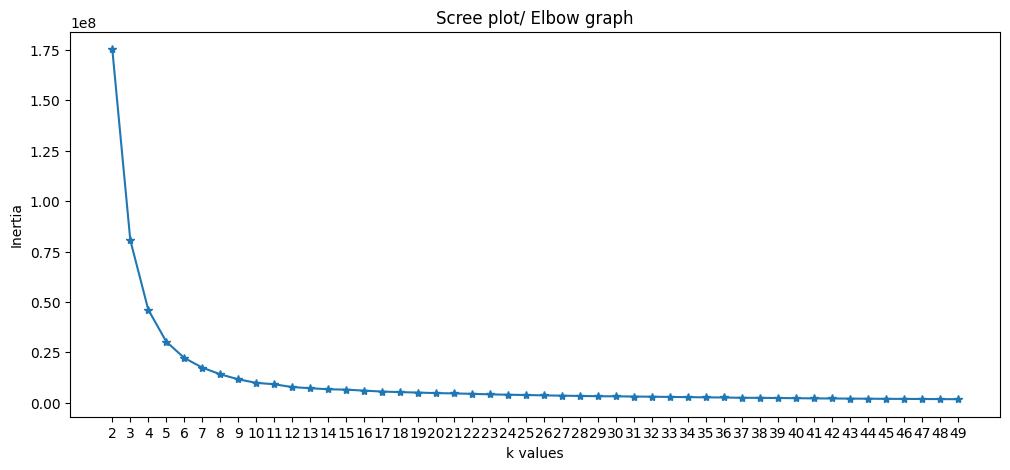

In [21]:

plt.figure(figsize=(12,5))
plt.plot(k,inertia,marker='*')
plt.title('Scree plot/ Elbow graph') 
plt.xlabel('k values')
plt.ylabel('Inertia')
plt.xticks(k)
plt.show()

### Choosing the optimal k value:
+ As the number of clusters increases, the WCSS/inertia typically decreases, because adding more clusters makes it easier to fit the data points closely.
  initially, the WCSS decreases sharply with the increase in the number of clusters.However, after a certain point, the rate of decrease slows down and 
  the curve starts to bend, forming an "elbow."
+ The "elbow" point is where the decrease in WCSS starts to slow down. This is usually considered the optimal number of clusters because adding more
  clusters beyond this point results in only marginal gains in terms of reduced WCSS, potentially leading to overfitting.

+ From above we can see that, around 10 clusters the elbow graph or the descrese in inertia values starts to slow down. Hence K =10 would be the optimal k value.

### Applying DBSCAN

In [22]:

# Parameters to search
# MinPts >= D+1
params = {'eps': list(np.arange(0.1, 0.9, 0.3)) + list(range(1, 20, 2)),
          'min_samples': [5,10,15,20,25]}

best_score = -1
best_params = {}

# Data for clustering
X = filtered_df.iloc[:, 1:]

# Manual grid search
for eps in params['eps']:
    for min_samples in params['min_samples']:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X)
        
        # Ignore noise points (label = -1) for silhouette score
        if len(set(labels)) > 1 and len(set(labels)) != 1 + (labels == -1).sum():  # Ensures that there are more than 1 clusters
            score = silhouette_score(X, labels)
            if score > best_score:
                best_score = score
                best_params = {'eps': eps, 'min_samples': min_samples}
                

print(f"Best Silhouette Score: {best_score}")
print(f"Best Parameters: {best_params}")

Best Silhouette Score: 0.12000355944994677
Best Parameters: {'eps': 11, 'min_samples': 5}


#### The silhouette score is very poor Hence we will not be considering DBSCAN.

### Applying PCA- Principal Component Analysis:

In [23]:

pca=PCA()
pca_components= pca.fit_transform(filtered_df.iloc[:,1:])
pca_components= pd.DataFrame(pca_components)

# preview of the PC's
pca_components

,0,1,2,3,4,5,6,7,8,9,10,11
0,708.697598,-45.231457,-5.257692,1.180572,-1.640615,0.118277,0.268834,-0.265093,0.097818,-0.559402,0.765139,0.112363
1,371.696918,-45.060376,-3.283272,0.508345,0.168675,1.114418,-0.065757,0.293708,-0.438848,0.083109,-0.110481,-0.683304
2,-511.302668,-44.592560,-3.473100,-0.926209,-0.817930,1.152785,0.744478,0.155907,0.779044,-0.069933,-0.456683,0.419281
3,300.695562,-45.037429,4.665873,1.237735,0.696485,-0.013784,1.423936,0.320136,-0.877906,0.348325,0.385052,0.270037
4,-142.303161,-44.788138,-1.414108,-1.714326,-0.287487,0.727452,0.924354,0.375126,0.423932,0.460659,-0.082140,0.319038
...,...,...,...,...,...,...,...,...,...,...,...,...
3369,-461.249363,61.355521,5.733254,0.814130,1.173874,-0.013406,-0.890205,-0.177984,1.073235,0.050820,-0.943341,-0.207068
3370,-691.247475,61.488413,-3.372312,1.631357,0.393121,-0.986428,-0.355452,-0.843698,-1.066323,0.057266,-0.355814,0.276086
3371,645.752356,60.793008,-4.078861,0.513277,1.018540,0.116992,-0.860324,0.786126,0.811531,-0.494048,-0.068009,0.446525
3372,-691.247484,61.485614,-3.348192,1.248285,0.279237,-1.591301,-0.716369,1.109021,-0.518722,-0.571973,-0.447088,0.346391


In [24]:
# PC's shouldn't be correletaed to each other and we can see below that they aren't correlated.
np.round(pca_components.corr(),4)

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0
2,0.0,0.0,1.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0
3,-0.0,0.0,0.0,1.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0
4,-0.0,-0.0,0.0,-0.0,1.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0
5,-0.0,-0.0,-0.0,-0.0,0.0,1.0,0.0,-0.0,-0.0,-0.0,0.0,0.0
6,-0.0,0.0,-0.0,-0.0,0.0,0.0,1.0,-0.0,-0.0,-0.0,-0.0,0.0
7,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,1.0,0.0,0.0,-0.0,-0.0
8,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,1.0,-0.0,-0.0,0.0
9,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,1.0,-0.0,-0.0


In [25]:
# Creating a dataframe to see the variances of all principal components
variance= pd.DataFrame(pca_components.var(), columns=['Variances'])
variance['Percentages']= pd.Series(pca.explained_variance_ratio_ * 100)
variance['cumsum']= pd.Series(np.cumsum(variance['Percentages']))
variance

,Variances,Percentages,cumsum
0,215692.767527,99.574786,99.574786
1,901.848680,0.416339,99.991125
2,12.581707,0.005808,99.996934
3,1.623267,0.000749,99.997683
4,1.237174,0.000571,99.998254
5,0.915422,0.000423,99.998677
6,0.746035,0.000344,99.999021
7,0.623216,0.000288,99.999309
8,0.500933,0.000231,99.999540
9,0.420226,0.000194,99.999734


#### From above we will be considering first three principal components as these retain 99.99 % of the variance.

#### Applying K-means to the selected principal components and evaluating the best scores:

In [26]:
print("Checking for the optimal k value:")
inertia=[]
silhouette=[]
k= list(range(2,20))
for i in k:
    kmeans=KMeans(n_clusters=i,random_state=42)
    kmeans.fit(pca_components.iloc[:,0:3])
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(pca_components.iloc[:,0:3],kmeans.labels_))
    print(f'K:{i} "Silhouette:"{silhouette_score(pca_components.iloc[:,0:3],kmeans.labels_)} Inertia:{kmeans.inertia_}' )

Checking for the optimal k value:
K:2 "Silhouette:"0.6315181140499837 Inertia:175307957.72055
K:3 "Silhouette:"0.5773195812525519 Inertia:80623901.3358563
K:4 "Silhouette:"0.553765489965261 Inertia:46110608.860849835
K:5 "Silhouette:"0.5343643180530386 Inertia:30338604.92124161
K:6 "Silhouette:"0.5171927085888306 Inertia:22229203.917250838
K:7 "Silhouette:"0.49522097191947695 Inertia:17411565.33395593
K:8 "Silhouette:"0.4730069976424254 Inertia:14095933.410128847
K:9 "Silhouette:"0.46982496219098063 Inertia:11606116.815453755
K:10 "Silhouette:"0.46519529681929184 Inertia:9841312.461946137
K:11 "Silhouette:"0.4459989682546644 Inertia:9145310.766030997
K:12 "Silhouette:"0.44026269372305915 Inertia:7743769.378259116
K:13 "Silhouette:"0.43152010490255094 Inertia:7288133.860955497
K:14 "Silhouette:"0.41502597936039454 Inertia:6730900.1014833925
K:15 "Silhouette:"0.39242988087910363 Inertia:6401527.534285517
K:16 "Silhouette:"0.3918357063330278 Inertia:5695084.410632916
K:17 "Silhouette:"0.3

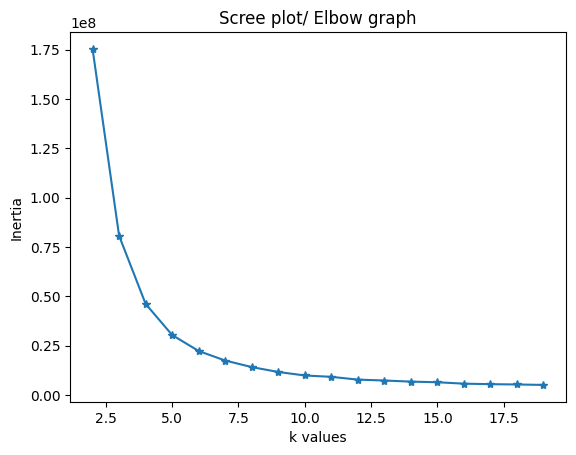

In [27]:
k= list(range(2,20))
plt.plot(k,inertia,marker='*')
plt.title('Scree plot/ Elbow graph') 
plt.xlabel('k values')
plt.ylabel('Inertia')
plt.show()

##### Even with the use of principal components, the optimal value for k is 10, as indicated by the elbow graph where the decrease in inertia begins to slow down at k=10.

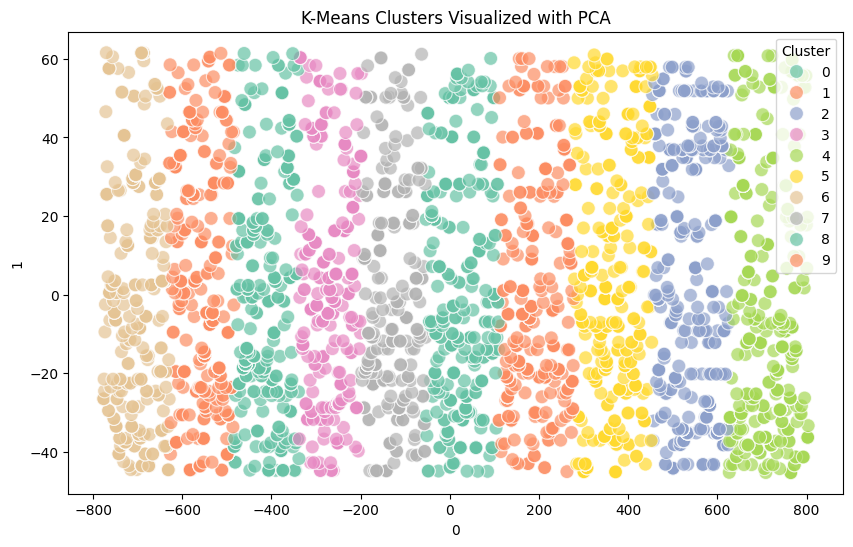

In [28]:
kmeans=KMeans(n_clusters=10,random_state=42)
labels=kmeans.fit_predict(pca_components.iloc[:,0:3])

# Create a DataFrame for the reduced data
df_pca = pd.DataFrame(pca_components.iloc[:,0:3])

# Add the cluster labels
df_pca['Cluster'] = labels

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca, x=df_pca.iloc[:,0], y=df_pca.iloc[:,1], hue='Cluster', palette='Set2', s=100, alpha=0.7)
plt.title('K-Means Clusters Visualized with PCA')
plt.show()

#### DBSCAN- PCA

In [29]:
# Parameters to search
params = {'eps': list(np.arange(0.1,0.9,0.2)) + list(range(1,20,2)),
          'min_samples': [5, 10, 12, 15, 20]}

best_score = -1
best_params = {}

# Data for clustering
X = pca_components.iloc[:,0:4]

# Manual grid search
for eps in params['eps']:
    for min_samples in params['min_samples']:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X)
        
        # Ignore noise points (label = -1) for silhouette score
        if len(set(labels)) > 1 and len(set(labels)) != 1 + (labels == -1).sum():  # Ensures that there are more than 1 clusters
            score = silhouette_score(X, labels)
            if score > best_score:
                best_score = score
                best_params = {'eps': eps, 'min_samples': min_samples}
                

print(f"Best Silhouette Score: {best_score}")
print(f"Best Parameters: {best_params}")

Best Silhouette Score: 0.13584785535083266
Best Parameters: {'eps': 9, 'min_samples': 5}


##### Still very poor silhouette score.

# Final cluster: Kmeans with k= 10

In [19]:
# applying kmeans to the preprocessd dataset

kmeans=KMeans(n_clusters=10,random_state=42)
Labels=kmeans.fit_predict(filtered_df.iloc[:,1:])

# Silhouette score
print("Silhouette score:",silhouette_score(filtered_df.iloc[:,1:], Labels))

# Add the cluster labels to the original dataset
filtered_df.loc[:, 'Cluster_id'] = Labels

# storing the clusters in the song copy file

songs_copy['Cluster_id']=Labels

Silhouette score: 0.46428305655615176


In [21]:

print("Value count in each cluster:\n",filtered_df.loc[:, 'Cluster_id'].value_counts())

Value count in each cluster:
 Cluster_id
4    397
2    378
8    347
5    340
1    334
6    333
0    332
9    317
3    316
7    280
Name: count, dtype: int64


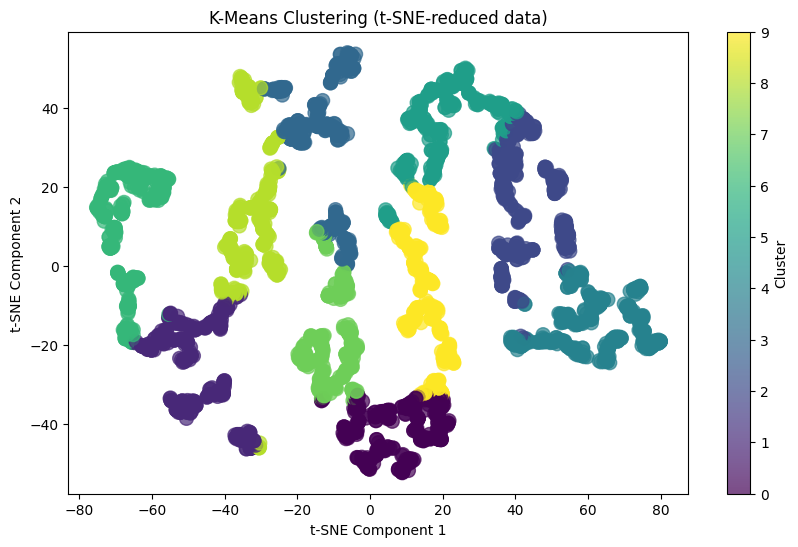

In [33]:
# Reduce dimensions to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(filtered_df.iloc[:, 1:]) 


# Create a DataFrame for t-SNE results
tsne_df = pd.DataFrame(data=X_tsne, columns=['t-SNE1', 't-SNE2'])
tsne_df['Cluster'] = Labels

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(tsne_df['t-SNE1'], tsne_df['t-SNE2'], c=tsne_df['Cluster'], cmap='viridis', s=100, alpha=0.7)
plt.title('K-Means Clustering (t-SNE-reduced data)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()

As observed above, the clusters are well-formed and clearly separated.

In [57]:
# Saving the final dataset
songs_copy.to_excel('final_tracks.xlsx',index=False)

# Model Building 1

In [22]:
# Function to recommend songs from the same cluster
def recommend_songs(song_name, data, num_recommendations):
    # Converting to lower case
    song_name=song_name.lower()
    data['Name']=data['Name'].str.lower()
    # checks if the song name is in the list of names of the dataset
    if song_name in data['Name'].values:
        # cluster stores the cluser id of the song
        cluster = data.loc[data['Name'] == song_name, 'Cluster_id'].values[0]
    # recommendation stores the sample of recommended songs
    recommendations = data[(data['Cluster_id'] == cluster) & (data['Name'] != song_name)].sample(num_recommendations)
    return recommendations[['Name','Artist','Genre']]

# Storing the list of recommended songs
recommendations = recommend_songs('hold on',songs_copy,10)
recommendations

,Name,Artist,Genre
1115,i'm every woman,Chaka Khan,disco
2746,guess featuring billie eilish,Charli xcx,pop
2029,don't,Bryson Tiller,hip-hop
1696,the insignificants,Cattle Decapitation,grindcore
1105,world hold on (children of the sky) - radio edit,Bob Sinclar,disco
2758,a sky full of stars,Coldplay,pop
1773,no rain,Blind Melon,grunge
2635,thank you for the music,Christian Lindquist,new-age
737,wizz - cobrah remix,COUCOU CHLOE,club
1546,evacuate the dancefloor - radio edit,Cascada,german


# Method 2 for recommendation:

### Data extraction using TfidfVectorizer for the text columns:

In [25]:
# Just dropping the cluser id and storing 
songs_df= songs_copy.drop(['Cluster_id'], axis=1)

In [26]:
songs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3374 entries, 0 to 3373
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          3374 non-null   object 
 1   Genre         3374 non-null   object 
 2   Artist        3374 non-null   object 
 3   Mode          3374 non-null   int64  
 4   Key           3374 non-null   int64  
 5   Popularity    3374 non-null   float64
 6   Danceability  3374 non-null   float64
 7   Energy        3374 non-null   float64
 8   Liveness      3374 non-null   float64
 9   Speechiness   3374 non-null   float64
 10  Tempo         3374 non-null   float64
 11  Valence       3374 non-null   float64
 12  Duration_ms   3374 non-null   float64
dtypes: float64(8), int64(2), object(3)
memory usage: 342.8+ KB


In [27]:

# Merging all the text columns
songs_df['Merged_col'] = (songs_df['Name'] + ' ' + songs_df['Artist'] + ' ' + songs_df['Genre'])


# Removing whitespace or filtering out any empty string
songs_df = songs_df[songs_df['Merged_col'].str.strip() != '']
Merged_data = songs_df['Merged_col']

# Converting to lower case
Merged_data = Merged_data.apply(lambda x: x.lower())

# Create an English language SnowballStemmer object
stemmer = SnowballStemmer("english")

# Define a function to perform both stemming and tokenization
def tokenize_and_stem(text):
    
    # Tokenize by sentence, then by word
    tokens = [word for sentence in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sentence)]

    stop_words= stopwords.words('english')

    no_stopwords_token= [x for x in tokens if x not in stop_words]
    
    # Stem the filtered_tokens
    stems = [stemmer.stem(t) for t in no_stopwords_token]
    
    return stems

In [28]:
Merged_data

0              blister in the sun violent femmes acoustic
1                       love song sara bareilles acoustic
2                       hold on chord overstreet acoustic
3          you are the best thing ray lamontagne acoustic
4                     i won't give up jason mraz acoustic
                              ...                        
3369               the launch - radio edit dj jean trance
3370    in the dark (feat. aldae) armin van buuren trance
3371                         split (only u) tiësto trance
3372    in the dark (feat. aldae) - extended mix armin...
3373    viva l'opera (asot 1186) [tune of the week] ar...
Name: Merged_col, Length: 3374, dtype: object

In [29]:
# printing all the tokens
songs_token = []
for i in Merged_data:
    tk = tokenize_and_stem(i)
    songs_token.append(tk)
    print(tk)

['blister', 'sun', 'violent', 'femm', 'acoust']
['love', 'song', 'sara', 'bareill', 'acoust']
['hold', 'chord', 'overstreet', 'acoust']
['best', 'thing', 'ray', 'lamontagn', 'acoust']
['wo', "n't", 'give', 'jason', 'mraz', 'acoust']
['born', 'love', 'ray', 'lamontagn', 'acoust']
['find', 'peopl', 'drew', 'holcomb', '&', 'neighbor', 'acoust']
['nake', 'came', 'iron', '&', 'wine', 'acoust']
['come', 'get', 'higher', 'matt', 'nathanson', 'acoust']
['flightless', 'bird', ',', 'american', 'mouth', 'iron', '&', 'wine', 'acoust']
['call', 'dream', 'iron', '&', 'wine', 'acoust']
['brand', 'new', 'ben', 'rector', 'acoust']
['asleep', 'among', 'endiv', 'ichiko', 'aoba', 'acoust']
['breath', '(', '2', ')', 'anna', 'nalick', 'acoust']
['ingrid', 'michaelson', 'acoust']
['save', 'later', 'eddi', 'vedder', 'acoust']
['stori', 'brandi', 'carlil', 'acoust']
['love', 'kurt', 'cobain', 'acoust']
['window', 'roll', 'amo', 'lee', 'acoust']
['upon', 'dream', 'disney', 'peac', 'guitar', 'acoust']
['babi', '

In [30]:
# Create a TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=1.0, max_features=5000, min_df=0.0, 
                                   use_idf=True, ngram_range=(1, 3), tokenizer=tokenize_and_stem,token_pattern=None)

# Fit and transform the Merged_data into a TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(Merged_data)

# The tfidf_matrix is now ready for use

In [31]:
# combining the tfidf matrix (text columns) and standardized numerical columns
combined_features = hstack([tfidf_matrix, songs_df[['Popularity', 'Danceability', 'Energy',
        'Liveness', 'Speechiness', 'Tempo', 'Valence',
       'Mode', 'Key', 'Duration_ms']]])


In [32]:
# Compute the cosine similarity matrix
cosine_sim = cosine_similarity(combined_features)
cosine_sim

array([[ 1.        ,  0.07607426,  0.15941996, ...,  0.02659492,
         0.19426253, -0.14016671],
       [ 0.07607426,  1.        ,  0.53138632, ...,  0.37537353,
         0.45563565,  0.72259891],
       [ 0.15941996,  0.53138632,  1.        , ...,  0.39006894,
         0.20777889,  0.63096665],
       ...,
       [ 0.02659492,  0.37537353,  0.39006894, ...,  1.        ,
         0.54725358,  0.56264741],
       [ 0.19426253,  0.45563565,  0.20777889, ...,  0.54725358,
         1.        ,  0.62987555],
       [-0.14016671,  0.72259891,  0.63096665, ...,  0.56264741,
         0.62987555,  1.        ]])

In [33]:
# converting the cosine similarity matrix into a dataframe
sim_df=pd.DataFrame(cosine_sim,columns=songs_df['Name'], index=songs_df['Name'])
# filling the digonal values to sero
np.fill_diagonal(sim_df.values, 0)
sim_df

Name,blister in the sun,love song,hold on,you are the best thing,i won't give up,i was born to love you,find your people,naked as we came,come on get higher,"flightless bird, american mouth",...,tell it to my heart,sorry you're not a winner,take me away (into the night) - vocal radio mix,lose this feeling - dimension remix,greece 2000,the launch - radio edit,in the dark (feat. aldae),split (only u),in the dark (feat. aldae) - extended mix,viva l'opera (asot 1186) [tune of the week]
Name,,,,,,,,,,,,,,,,,,,,,
blister in the sun,0.000000,0.076074,0.159420,0.072030,-0.048631,0.056666,0.179352,0.107657,0.149356,-0.149473,...,-0.045877,-0.003545,-0.157589,-0.314690,0.286099,-0.053705,0.255822,0.026595,0.194263,-0.140167
love song,0.076074,0.000000,0.531386,0.803034,0.627135,0.733716,0.731771,0.577226,0.783921,0.578650,...,0.735148,0.675016,0.691409,0.085539,0.508111,0.760189,0.522803,0.375374,0.455636,0.722599
hold on,0.159420,0.531386,0.000000,0.606146,0.832886,0.748362,0.689554,0.657757,0.681083,0.772214,...,0.584078,0.585388,0.633952,-0.125067,0.107440,0.612030,0.169107,0.390069,0.207779,0.630967
you are the best thing,0.072030,0.803034,0.606146,0.000000,0.811834,0.897881,0.873274,0.837165,0.947110,0.744911,...,0.932449,0.890089,0.844346,0.118136,0.534620,0.940714,0.675157,0.437830,0.636500,0.922396
i won't give up,-0.048631,0.627135,0.832886,0.811834,0.000000,0.895962,0.808494,0.831670,0.836215,0.907171,...,0.778429,0.780603,0.773937,-0.059201,0.176318,0.800403,0.317885,0.381351,0.359649,0.839338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
the launch - radio edit,-0.053705,0.760189,0.612030,0.940714,0.800403,0.916990,0.884161,0.706617,0.942653,0.691201,...,0.970873,0.930670,0.901490,0.082869,0.457194,0.000000,0.602207,0.507646,0.594345,0.963212
in the dark (feat. aldae),0.255822,0.522803,0.169107,0.675157,0.317885,0.494594,0.635201,0.470947,0.621590,0.257872,...,0.689489,0.513856,0.520706,0.235770,0.531434,0.602207,0.000000,0.301044,0.766959,0.604639
split (only u),0.026595,0.375374,0.390069,0.437830,0.381351,0.389337,0.352567,0.211366,0.446352,0.361919,...,0.539875,0.595990,0.499172,0.283519,0.414397,0.507646,0.301044,0.000000,0.547254,0.562647


# Model building 2

In [34]:
# defining a function to recommend song based on the cosine similarity matrix
def recommend_songs(song_name, sim_matrix, data,top_n):
    # converting the name to lower case
    song_name=song_name.lower()
    # Storing all the similarity scores of the song
    sim_values=sim_matrix[song_name].values.tolist()
    # enumerating the values
    sim_values=enumerate(sim_values)
    # Sorting the values in descending order
    sim_values=sorted(sim_values, key=lambda x: x[1], reverse=True)
    # Storing the top n song indices
    top_n_indices=[x[0] for x in sim_values[0:top_n+1]]
    
    return data.iloc[top_n_indices,0:3]

In [35]:
recommend_songs('hold on', sim_df, songs_df,10)

,Name,Genre,Artist
3116,photograph,singer-songwriter,Ed Sheeran
3032,can we kiss forever?,sad,Kina
2711,your song,piano,Elton John
445,easy on me,british,Adele
821,heading south,country,Zach Bryan
345,"up where we belong - from ""an officer and a ge...",blues,Joe Cocker
723,lost in the fire (feat. the weeknd),club,Gesaffelstein
144,nothing's gonna hurt you baby,ambient,Cigarettes After Sex
4,i won't give up,acoustic,Jason Mraz
852,i was all over her,country,salvia palth
